In [54]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from string import digits
import re
import os
import io
import time

In [55]:
path_to_file = "/content/drive/MyDrive/Colab Notebooks/kor.txt"

In [56]:
lines = pd.read_table(path_to_file, names=['source', 'target', 'others'])
lines = lines[['source', 'target']]
lines.head()

,source,target
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?


In [57]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/kor2.txt', lines.values, fmt='%s', delimiter="\t")

In [58]:
path_to_nfile = "/content/drive/MyDrive/Colab Notebooks/kor2.txt"

In [59]:
# Text preprocessing
def preprocess_sentence(x):


  # Lowercase
  x = x.lower()

  x = re.sub(" +", " ", x)
  x = re.sub("'", '', x)

  # Add space between letter and punctuation
  x = re.sub(r"([?.!,¿])", r" \1 ", x)
  x = re.sub(r'[" "]+', " ", x)

  x = x.strip()

  # Add start and end token to sentences
  x = '<start> ' + x + ' <end>'
  return x

In [60]:
en_sentence = u"Do you like cooking?"
kr_sentence = u"요리 좋아해?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(kr_sentence))

<start> do you like cooking ? <end>
<start> 요리 좋아해 ? <end>


In [61]:
# Cleaning text 
# Add word pairs
def create_dataset(path, num_examples):
  
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  
  return zip(*word_pairs)

In [62]:
# En-Kor word pairs | Source-Target
sample_size = 50000
en, kr = create_dataset(path_to_nfile, sample_size)

In [63]:
# Tokenizer for source (en)
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
source_tokenizer.fit_on_texts(en)
# Sequencing
source_tensor = source_tokenizer.texts_to_sequences(en)
# Padding
source_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post')

In [64]:
# Tokenizer for target (kr)
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
target_tokenizer.fit_on_texts(kr)
# Sequencing
target_tensor = target_tokenizer.texts_to_sequences(kr)
# Padding
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post')

In [65]:
# TTS
source_train, source_test, target_train, target_test = train_test_split(source_tensor, target_tensor, test_size=0.2)

In [66]:
# Some parameters
BATCH_SIZE = 8
BUFFER_SIZE = len(source_train)
steps = len(source_train) // BATCH_SIZE
embedding_dim = 256
units = 1024

# Vocab size
source_vocab_size = len(source_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((source_train, target_train)).shuffle(BATCH_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
source_batch, target_batch = next(iter(dataset))


In [67]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size= batch_size
        self.encoder_units=encoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru= tf.keras.layers.GRU(encoder_units, 
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        #pass the input x to the embedding layer
        x= self.embedding(x)
        # pass the embedding and the hidden state to GRU
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [68]:
encoder = Encoder(source_vocab_size, embedding_dim, units, BATCH_SIZE)


In [69]:
# Bahdanau Attention Layer
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1= tf.keras.layers.Dense(units)  # Encoder output
    self.W2= tf.keras.layers.Dense(units)  # Decoder hidden
    self.V= tf.keras.layers.Dense(1)
  
  def call(self, query, values):
    #calculate the Attention score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    
      #context_vector 
    context_vector = attention_weights * values
    
    #Computes the sum of elements across dimensions of a tensor
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [70]:
# Decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
    super(Decoder,self).__init__()
    self.batch_size = batch_size
    self.decoder_units = decoder_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(decoder_units, 
                                   return_sequences= True, 
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # Fully connected layer
    self.fc= tf.keras.layers.Dense(vocab_size)
    
    # attention
    self.attention = BahdanauAttention(self.decoder_units)
    
  def call(self, x, hidden, encoder_output):
    context_vector, attention_weights = self.attention(hidden, encoder_output)
    
    # pass output sequnece thru the input layers
    x = self.embedding(x)
    
    # concatenate context vector and embedding for output sequence
    x = tf.concat([tf.expand_dims( context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # output shape == (batch_size * 1, hidden_size)
    output= tf.reshape(output, (-1, output.shape[2]))
    
    # pass the output thru Fc layers
    x = self.fc(output)
    return x, state, attention_weights

In [71]:
decoder = Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)

In [72]:
# Optimizer
optimizer = tf.keras.optimizers.Adam()
# Loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):                      
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [80]:
# Training
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [74]:
EPOCHS = 1

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
      
  # saving (checkpoint) the model every 2 epochs
  # if (epoch + 1) % 2 == 0:
  #   checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 0.4665137231349945
Epoch 1 Batch 100 loss 0.3764806389808655
Epoch 1 Batch 200 loss 0.36541956663131714
Epoch 1 Batch 300 loss 0.35685038566589355
Epoch 1 Loss 0.3799
Time taken for 1 epoch 463.4818766117096 sec



In [75]:
#Calculating the max length of the source and target sentences
max_target_length= max(len(t) for t in target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [81]:
def evaluate(sentence):
  attention_plot= np.zeros((max_target_length, max_source_length))
  #preprocess the sentnece
  sentence = preprocess_sentence(sentence)
  
  #convert the sentence to index based on word2index dictionary
  inputs= [source_tokenizer.word_index[i] for i in sentence.split(' ')]
  
  # pad the sequence 
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_source_length, padding='post')
  
  #conver to tensors
  inputs = tf.convert_to_tensor(inputs)
  
  result= ''
  
  # creating encoder
  hidden = [tf.zeros((1, units))]
  encoder_output, encoder_hidden= encoder(inputs, hidden)
  
  # creating decoder
  decoder_hidden = encoder_hidden
  decoder_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)
    
  for t in range(max_target_length):

    predictions, decoder_hidden, attention_weights= decoder(decoder_input, decoder_hidden, encoder_output)
    
    # storing attention weight for plotting it
    attention_weights = tf.reshape(attention_weights, (-1,))
    attention_plot[t] = attention_weights.numpy()
    
    prediction_id= tf.argmax(predictions[0]).numpy()
    result += target_tokenizer.index_word[prediction_id] + ' '
    
    if target_tokenizer.index_word[prediction_id] == '<end>':
      return result,sentence, attention_plot
    
    # predicted id is fed back to as input to the decoder
    decoder_input = tf.expand_dims([prediction_id], 0)
      
  return result,sentence, attention_plot

In [77]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax= fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap='Greens')
  fontdict={'fontsize':10}
  
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [82]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input : %s' % (sentence))
  print('predicted sentence :{}'.format(result))
  
  attention_plot= attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input : <start> oh no something is missing . . . <end>
predicted sentence :난 . . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45212 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45212 missing from current font.
  font.set_text(s, 0, flags=flags)


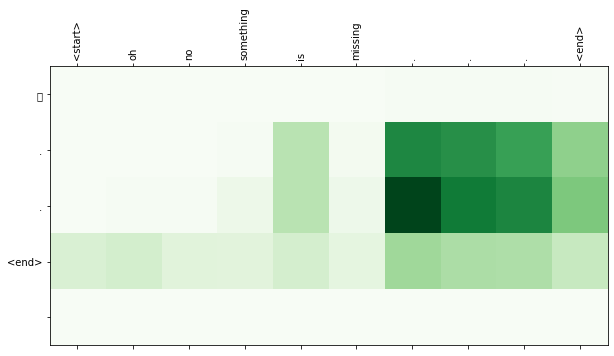

In [90]:
translate(u'Oh no something is missing...')